In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier as rfc
from scipy.ndimage import gaussian_filter
%matplotlib inline

# Machine Learning Classifier Attemps for KBMOD

## Make training set

### False Dataset

Our false data is a set of postage stamps actually collected from KBMOD that were false positives coming through the pipeline. These were obtained when recovering known objects in Pointing Group 010 to 089 in the Lori Allen NEO dataset

In [4]:
full_false = np.load('/epyc/users/smotherh/kbmod_epyc/notebooks/stamp_training_set.npy')

### Make real dataset

Make some real Gaussians and add noise to use as truth for training. Add them to a background from real images and searched along a trajectory. Add some scatter in the alignment and some variance to the PSF size.

In [5]:
# import os
# from astropy.io import fits
# import matplotlib.dates as mdates
# import datetime as dt
# from dateutil.parser import parse
# import multiprocessing as mp
# import pickle

# with open('/epyc/users/smotherh/LoriAllen/pointing_metadata/PickledPointings.pkl', 'rb') as f:
#     Pointing_Groups = pickle.load(f)

# # Import the times
# times=[[]]*len(Pointing_Groups)
# for i,pointing in enumerate(Pointing_Groups):
#     times[i]=np.array([0.]*len(Pointing_Groups[i]['date_obs']))
#     for j in range(len(Pointing_Groups[i]['date_obs'])):
#         foo = parse(Pointing_Groups[i]['date_obs'][j])
#         times[i][j]= foo.timestamp()
        
# def makeSyntheticCoadd(pgccd):
#     """
#     This function generates a synthetic coadd for a given pointing group and ccd.
#     It generates a random trajectory along the visits and uses those to get 21x21
#     pixel stamps. It puts a gaussian with a semi-random PSF in each stamp, with
#     some scatter for the central pixel. It adds a linear offset to the stamps.
#     It then returns the median of all the stamps.
#     """
#     pg_num = pgccd[0]
#     ccd = pgccd[1]
#     visit_list = Pointing_Groups[pg_num]['visit_id']
#     cutout_size = 21 # pixels
#     speed_lims = [100,300] # px/day
#     ang_lims = [0,np.pi/2] # radians
#     time_baseline = (times[pg_num][-1]-times[pg_num][0])/(3600*24) # days
    
#     # Set a 2 pixel potential velocity offset
#     max_x_vel_offset = 4*(0.5-np.random.random())
#     max_y_vel_offset = 4*(0.5-np.random.random())
#     visit_num = len(visit_list)
    
#     if ccd==2 or ccd==61:
#         return([])
#     pg_object_list = []
#     for i,visit_id in enumerate(visit_list):
#         net_x_offset = (1-2*np.random.random())/2
#         net_y_offset = (1-2*np.random.random())/2
#         imagePath = '/epyc/users/smotherh/DECAM_Data_Reduction/pointing_groups_hyak/Pointing_Group_{:03d}'
#         diffPath = os.path.join(imagePath.format(pg_num),'warps/{:02d}/{}.fits'.format(int(ccd),visit_id))
#         try:
#             hdul = fits.open(diffPath)
#         except:
#             continue
#         data = hdul[1].data
#         # Compute the values of various parameters for this specific stamp.
#         # Uses the limits defined above.
#         data_size = np.shape(data)
#         speed = (speed_lims[1]-speed_lims[0]) * np.random.random() + speed_lims[0]
#         angle = (ang_lims[1]-ang_lims[0]) * np.random.random() + ang_lims[0]
#         vel = [speed*np.cos(angle), speed*np.sin(angle)]
#         starting_pixel_xy_max = [data_size[1] - 100 - speed*time_baseline, data_size[0] - 100 - speed*time_baseline]
#         start_px = [50+starting_pixel_xy_max[0]*np.random.random(), 50+starting_pixel_xy_max[1]*np.random.random()]
#         min_gauss_sigma = 1
#         brightness_lims = [150,4000]
#         object_brightness = (brightness_lims[1]-brightness_lims[0])*np.random.random() + brightness_lims[0]
#         elapsed_time = (times[pg_num][i] - times[pg_num][0])/(3600*24)
#         pixel = [start_px[0]+vel[0]*elapsed_time, start_px[1]+vel[1]*elapsed_time]
#         min_x = int(pixel[0]-(cutout_size-1)/2)-1
#         max_x = int(pixel[0]+(cutout_size-1)/2)
#         min_y = int(pixel[1]-(cutout_size-1)/2)-1
#         max_y = int(pixel[1]+(cutout_size-1)/2)
#         cutout = np.copy(data[min_y:max_y,min_x:max_x])
#         cutout[np.isnan(cutout)] = 0
#         #cutout -= np.min(cutout)
#         #cutout /= np.sum(cutout)
#         cutout_edge = (cutout_size-1)/2                                                   
#         x = np.linspace(-cutout_edge, cutout_edge, cutout_size)
#         y = np.linspace(-cutout_edge, cutout_edge, cutout_size)
#         x, y = np.meshgrid(x, y)
#         sigma = np.random.random()+min_gauss_sigma
#         gaussian_kernel = (object_brightness * (1/(2*np.pi*sigma*sigma) 
#             * np.exp(-((x-net_x_offset-max_x_vel_offset*(i/visit_num))**2/(2*sigma**2) + (y-net_y_offset-max_y_vel_offset*(i/visit_num))**2/(2*sigma**2))))
#             * (1+(0.1*(np.random.random(cutout_size*cutout_size).reshape(cutout_size,cutout_size)-0.5)))) # add 3% noise to psf)
#         #sim_object = np.zeros((cutout_size, cutout_size))
#         #sim_object[int((cutout_size-1)/2), int((cutout_size-1)/2)] = object_brightness
#         #sim_object = gaussian_filter(sim_object, np.random.random()+min_gauss_sigma)
#         sim_object = cutout + gaussian_kernel
#         pg_object_list.append(sim_object)
#     if len(pg_object_list)>0:
#         median_coadd = np.median(pg_object_list, axis=0)
#     else:
#         median_coadd = []
#     return(median_coadd)

In [6]:
# # Generate the stamps using the above function.
# # This will take a while (approx. 2 hours)
# all_results = []
# pg_list = np.linspace(91,110,20).astype(int)
# foo = np.linspace(1,62,62).astype(int)
# foo = foo[foo!=2]
# ccd_list = foo[foo!=61]
# pgccd_list = []
# for pg in pg_list:
#     for ccd in ccd_list:
#         pgccd_list.append([pg,ccd])
# with mp.Pool(20) as pool:
#     for j in range(50):
#         results = pool.map(makeSyntheticCoadd, pgccd_list)
#         all_results.append(results)

In [7]:
# # Save the stamps
# all_coadd_stamps = np.concatenate(all_results, axis=0)
# np.save('stamps_simulated.npy', all_coadd_stamps)

In [8]:
full_true=np.load('/epyc/users/smotherh/kbmod_epyc/notebooks/stamps_simulated_v3.npy')

## Train the CNN

In [9]:
stamp_class = np.zeros(len(full_false) + len(full_true))
stamp_class[len(full_false):] = 1

In [10]:
input_stamps = np.vstack([full_false.reshape(len(full_false), 21*21), full_true.reshape(len(full_true), 21*21)])

Shuffle data in a way we can reconstruct

In [11]:
rand_state = np.random.RandomState(32)
idx = rand_state.permutation(len(input_stamps))
input_stamps = input_stamps[idx]
stamp_class = stamp_class[idx]
#stamp_class = to_categorical(stamp_class)

Use 70% of data for training, 20% for validation and 10% for test.

In [12]:
train_len = np.int(0.7*len(stamp_class))
val_len = np.int(0.2*len(stamp_class))
test_len = len(stamp_class) - train_len - val_len

train_data = input_stamps[:train_len]
train_data -= np.min(train_data, axis=1).reshape(-1,1)
train_data /= np.sum(train_data, axis=1).reshape(-1,1)
train_class = stamp_class[:train_len]
val_data = input_stamps[train_len:train_len+val_len]
val_data -= np.min(val_data, axis=1).reshape(-1,1)
val_data /= np.sum(val_data, axis=1).reshape(-1,1)
val_class = stamp_class[train_len:train_len+val_len]
test_data = input_stamps[train_len+val_len:]
test_data -= np.min(test_data, axis=1).reshape(-1,1)
test_data /= np.sum(test_data, axis=1).reshape(-1,1)
test_class = stamp_class[train_len+val_len:]

In [13]:
train_len, val_len, test_len, len(stamp_class)

(76984, 21995, 10999, 109978)

In [14]:
len(train_data), len(val_data), len(test_data), len(stamp_class)

(76984, 21995, 10999, 109978)

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Dataset

class Net(torch.nn.Module):

    # Using this as guide github.com/MorvanZhou/PyTorch-Tutorial/blob/
    # master/tutorial-contents/301_regression.py

    def __init__(self, n_input_features, n_hidden_nodes, n_output):

        super(Net, self).__init__()

        # Set up layers

        self.hidden_1 = torch.nn.Linear(n_input_features, n_hidden_nodes)
        self.hidden_2 = torch.nn.Linear(n_hidden_nodes, n_output)
        self.predict = torch.nn.LogSoftmax()

        self.train_mean = None
        self.train_stdev = None

    def forward(self, x):

        x = F.relu(self.hidden_1(x))
        #x = F.relu(self.hidden_2(x.view(256, 1, 64)))
        x = F.relu(self.hidden_2(x))
        x = self.predict(x)

        return x

In [390]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Dataset

class Net(torch.nn.Module):

    # Using this as guide github.com/MorvanZhou/PyTorch-Tutorial/blob/
    # master/tutorial-contents/301_regression.py

    def __init__(self, n_input_features, n_hidden_nodes, n_output):

        super(Net, self).__init__()

        # Set up layers

        self.hidden_1 = torch.nn.Linear(n_input_features, n_hidden_nodes)
        self.hidden_2 = torch.nn.AvgPool1d(4, 2)
        self.hidden_3 = torch.nn.Linear(31, 2)
        self.predict = torch.nn.LogSoftmax()

        self.train_mean = None
        self.train_stdev = None

    def forward(self, x):

        batch_size = len(x)
        x = F.relu(self.hidden_1(x))
        x = F.relu(self.hidden_2(x.view(batch_size, 1, 64)))
        x = F.relu(self.hidden_3(x))
        x = self.predict(x.view(batch_size, 2))

        return x

In [20]:
n_epochs = 250
train_len = len(train_data)

net = Net(441, 64, 2)

optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
loss_func = torch.nn.NLLLoss()

train_loss_curve = []
val_loss_curve = []

In [21]:
train_true = np.zeros((len(train_class), 2))
for i in range(len(train_true)):
    train_true[i, int(train_class[i])] = 1.
    
val_true = np.zeros((len(val_class), 2))
for i in range(len(val_true)):
    val_true[i, int(val_class[i])] = 1.
    
for t in range(n_epochs):
    
    print('On Epoch %i' % (t+1))
    
    batch_size = 128
    batch_indices = torch.randperm(train_len).numpy()
    
    epoch_loss = []
    
    for batch_start in range(0, train_len, batch_size):
        
        batch_idx = batch_indices[batch_start:batch_start+batch_size]
        nn_input = train_data[batch_idx]
            
        # If last batch is not of batch_size change batch_size
        if len(nn_input) < batch_size:
            batch_size = len(nn_input)

        nn_input = torch.tensor(nn_input, dtype=torch.float)
            
        true_output = train_true[batch_idx]

        true_output = torch.tensor(true_output,
                                   dtype=torch.float).reshape(
                                            batch_size, 2)

        prediction = net(nn_input)

        loss = loss_func(prediction, np.argmax(true_output, axis=1))
        
        epoch_loss.append(loss.data)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss_curve.append(np.mean(epoch_loss))
                
    nn_input = torch.tensor(val_data, dtype=torch.float)
    true_output = torch.tensor(val_true,
                                   dtype=torch.float).reshape(
                                           len(val_true), 2)
    prediction = net(nn_input)
    loss = loss_func(prediction, np.argmax(true_output, axis=1))
    val_loss_curve.append(loss.data)

    if (t+1) % 2 == 0:
        print('After %i epochs' % (t+1))
        print(loss.data)

On Epoch 1


/phys/users/brycek/.conda/envs/py3-bryce/lib/python3.7/site-packages/ipykernel/__main__.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


On Epoch 2
After 2 epochs
tensor(0.6886)
On Epoch 3
On Epoch 4
After 4 epochs
tensor(0.6884)
On Epoch 5
On Epoch 6
After 6 epochs
tensor(0.6883)
On Epoch 7
On Epoch 8
After 8 epochs
tensor(0.6882)
On Epoch 9
On Epoch 10
After 10 epochs
tensor(0.6880)
On Epoch 11
On Epoch 12
After 12 epochs
tensor(0.6880)
On Epoch 13
On Epoch 14
After 14 epochs
tensor(0.6878)
On Epoch 15
On Epoch 16
After 16 epochs
tensor(0.6876)
On Epoch 17
On Epoch 18
After 18 epochs
tensor(0.6875)
On Epoch 19
On Epoch 20
After 20 epochs
tensor(0.6872)
On Epoch 21
On Epoch 22
After 22 epochs
tensor(0.6870)
On Epoch 23
On Epoch 24
After 24 epochs
tensor(0.6867)
On Epoch 25
On Epoch 26
After 26 epochs
tensor(0.6864)
On Epoch 27
On Epoch 28
After 28 epochs
tensor(0.6860)
On Epoch 29
On Epoch 30
After 30 epochs
tensor(0.6856)
On Epoch 31
On Epoch 32
After 32 epochs
tensor(0.6851)
On Epoch 33
On Epoch 34
After 34 epochs
tensor(0.6845)
On Epoch 35
On Epoch 36
After 36 epochs
tensor(0.6839)
On Epoch 37
On Epoch 38
After 38 e

Text(0, 0.5, 'Loss')

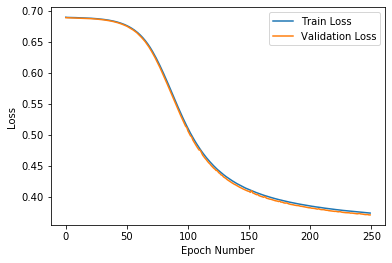

In [23]:
plt.plot(np.arange(n_epochs), train_loss_curve, label='Train Loss')
plt.plot(np.arange(n_epochs), val_loss_curve, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch Number')
plt.ylabel('Loss')

## Predict Test Data

In [24]:
test_true = np.zeros((len(test_class), 2))
for i in range(len(test_true)):
    test_true[i, int(test_class[i])] = 1.

nn_input = torch.tensor(test_data, dtype=torch.float)
true_output = torch.tensor(test_true,
                                   dtype=torch.float).reshape(
                                           len(test_true), 2)
prediction = net(nn_input)

/phys/users/brycek/.conda/envs/py3-bryce/lib/python3.7/site-packages/ipykernel/__main__.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


(array([4687.,  311.,  214.,  159.,  171.,  252.,  251.,  387.,  583.,
        3984.]),
 array([0.5       , 0.54999626, 0.5999926 , 0.64998883, 0.6999851 ,
        0.7499814 , 0.79997766, 0.8499739 , 0.8999702 , 0.9499665 ,
        0.99996275], dtype=float32),
 <a list of 10 Patch objects>)

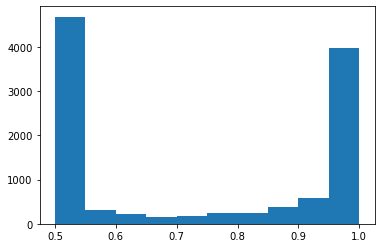

In [28]:
plt.hist(np.exp(prediction[:, 1].detach().numpy()))

In [29]:
test_probs = np.exp(prediction[:, 1].detach().numpy())

In [30]:
fpr = []
tpr = []
for cutoff in np.arange(0.01, 1.0, 0.01):
    correct_false = []
    correct_true = []
    false_positive = []
    false_negative = []
    index = 0
    for true_class, result_prob in zip(test_class, test_probs):
        if true_class == 0.:
            if result_prob < cutoff:
                correct_false.append(index)
            else:
                false_positive.append(index)
        else:
            if result_prob < cutoff:
                false_negative.append(index)
            else:
                correct_true.append(index)
        index+=1
    fpr.append(len(false_positive)/len(np.where(test_class == 0)[0]))
    tpr.append(len(correct_true)/len(np.where(test_class == 1)[0]))

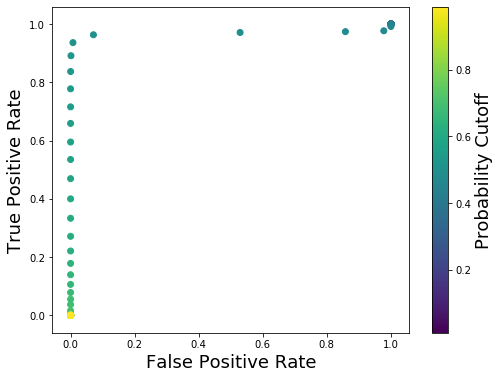

In [401]:
fig = plt.figure(figsize=(8,6))
plt.scatter(fpr, tpr, c=np.arange(0.01, 1.0, 0.01))
cbar = plt.colorbar()
plt.xlabel('False Positive Rate', size=18)
plt.ylabel('True Positive Rate', size=18)
cbar.set_label('Probability Cutoff', size=18)

In [41]:
correct_false = []
correct_true = []
false_positive = []
false_negative = []
index = 0
cutoff = 0.75
for true_class, result_prob in zip(test_class, test_probs):
    if true_class == 0.:
        if result_prob < cutoff:
            correct_false.append(index)
        else:
            false_positive.append(index)
    else:
        if result_prob < cutoff:
            false_negative.append(index)
        else:
            correct_true.append(index)
    index+=1

In [42]:
torch_results = np.array([[len(correct_true), len(false_positive)], [len(false_negative), len(correct_false)]])

(2, 0)

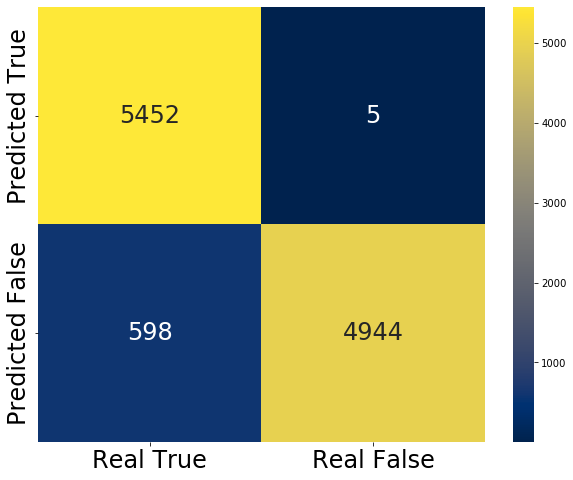

In [43]:
fig = plt.figure(figsize=(10,8))
sns.heatmap(torch_results, annot=True, annot_kws={'size':24}, cmap=plt.get_cmap('cividis'), fmt='g')
plt.xticks([0.5, 1.5], ['Real True', 'Real False'], size=24)
plt.yticks([0.5, 1.5], ['Predicted True', 'Predicted False'], size=24, va='center')
plt.ylim(2, 0)

### Look at False Negatives and False Positives

Text(0.5, 0.98, 'False Negatives')

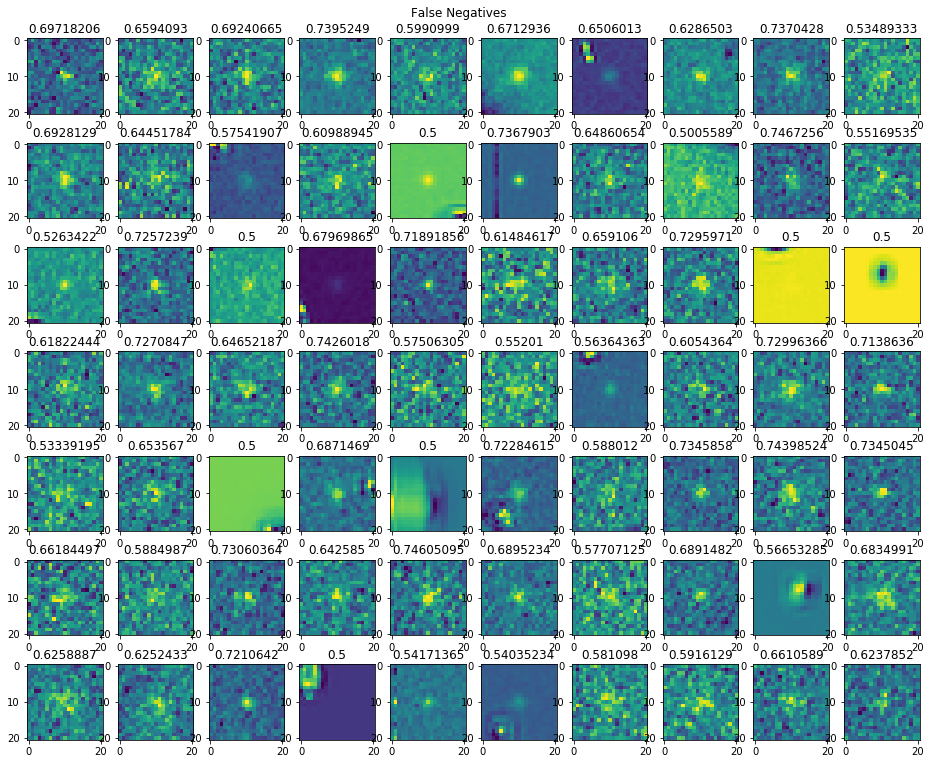

In [44]:
fig = plt.figure(figsize=(16, 12))
for i in range(70):
    fig.add_subplot(7, 10, i+1)
    plt.imshow(test_data[false_negative[i]].reshape(21,21))
    plt.title(test_probs[false_negative[i]])
plt.subplots_adjust(top=0.95)
plt.suptitle('False Negatives')

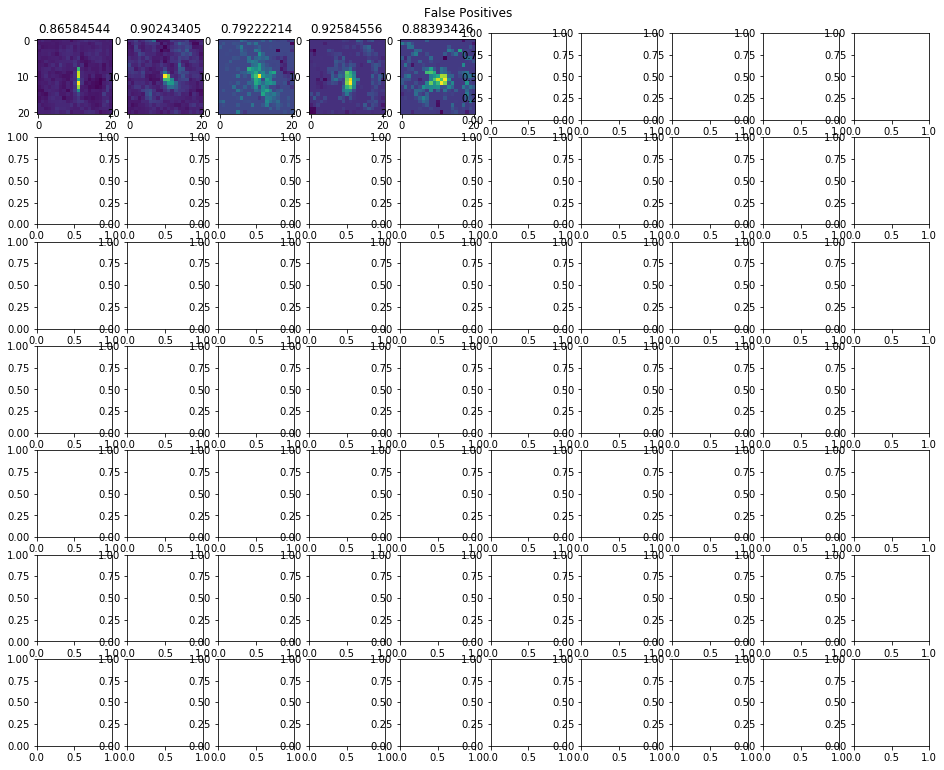

In [45]:
fig = plt.figure(figsize=(16, 12))
for i in range(70):
    fig.add_subplot(7, 10, i+1)
    try:
        plt.imshow(test_data[false_positive[i]].reshape(21,21))
        plt.title(test_probs[false_positive[i]])
    except:
        continue
plt.suptitle('False Positives')
plt.subplots_adjust(top=0.95)
#plt.tight_layout()

## Save Model